In [39]:
import pandas as pd
import thinkstats2 as ts2
import thinkplot as tp
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import math
%matplotlib inline

In [40]:
df = pd.read_csv("dataframe.csv")

In [41]:
df.columns = ['date', 'weekday', 'rain', 'snowdepth', 'snow', 'trips', 'pmt']

In [42]:
df["date"]=pd.to_datetime(df.date, infer_datetime_format=True)

In [43]:
class CorrelationPermuate(ts2.HypothesisTest):
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(ts2.Corr(xs, ys))
        return test_stat
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

class CovariancePermutate(ts2.HypothesisTest):    
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(ts2.Cov(xs, ys))
        return test_stat
    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys
    
class DiffMeansPermutate(ts2.HypothesisTest):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat
    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))
    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

(array([   2.,    0.,    0.,    1.,    2.,    2.,    1.,    0.,    2.,
           3.,    3.,    4.,   25.,   54.,   89.,   88.,  112.,  136.,
         166.,  150.,  118.,   95.,   69.,   37.,   14.]),
 array([  517359.  ,   608741.56,   700124.12,   791506.68,   882889.24,
          974271.8 ,  1065654.36,  1157036.92,  1248419.48,  1339802.04,
         1431184.6 ,  1522567.16,  1613949.72,  1705332.28,  1796714.84,
         1888097.4 ,  1979479.96,  2070862.52,  2162245.08,  2253627.64,
         2345010.2 ,  2436392.76,  2527775.32,  2619157.88,  2710540.44,
         2801923.  ]),
 <a list of 25 Patch objects>)

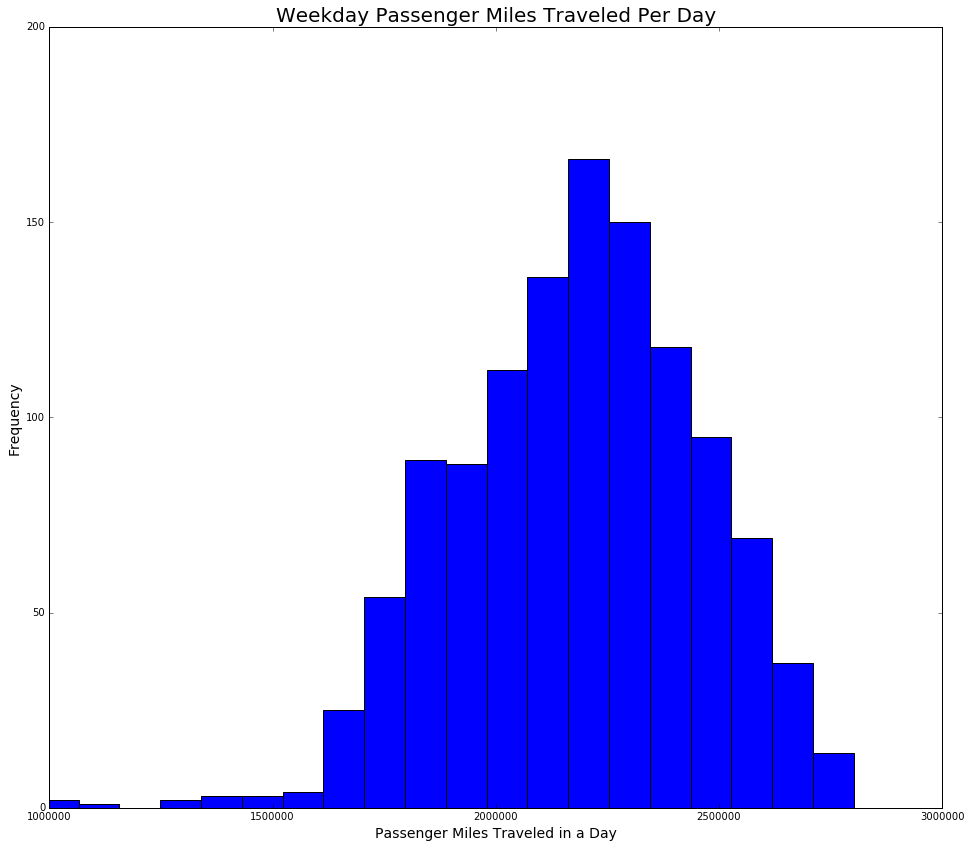

In [44]:
df = df[df.pmt>0]
plt.figure(figsize=(16,14))
plt.title("Weekday Passenger Miles Traveled Per Day", fontsize=20)
plt.xlabel("Passenger Miles Traveled in a Day", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.axis([1000000, 3000000, 0, 200])
plt.hist(df[df.weekday<6].pmt, bins=25)

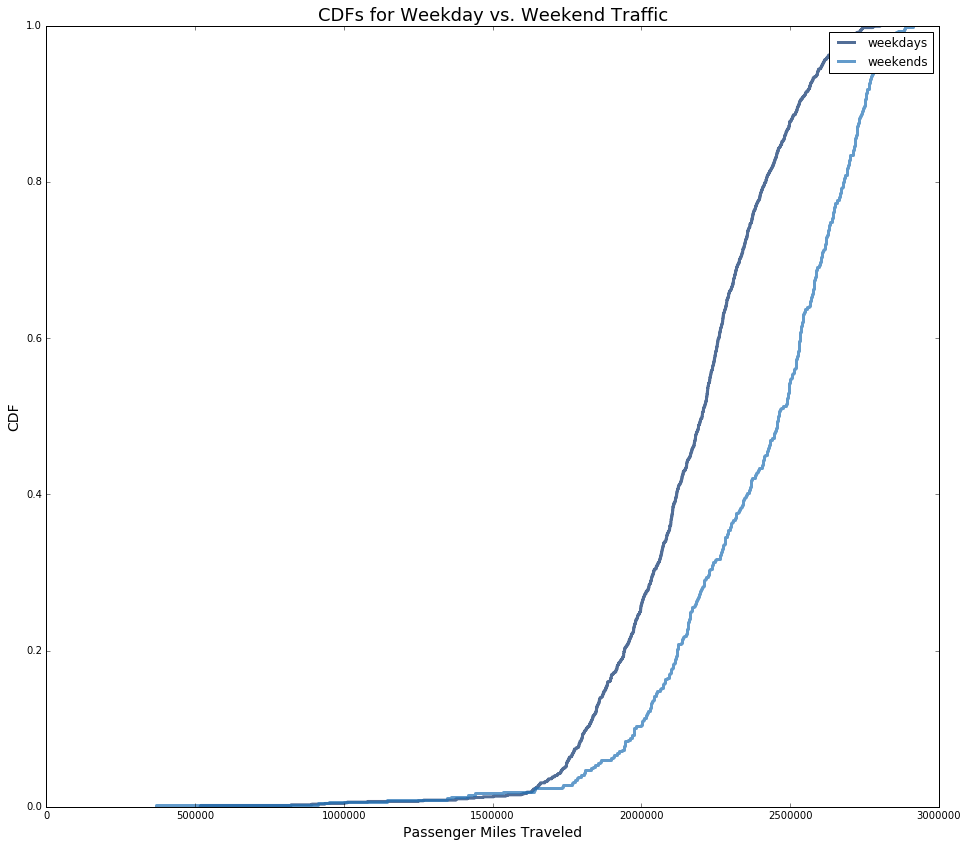

In [45]:
weekdays = df[df.weekday<6]
weekends = df[df.weekday>5]
weekday_pmt_cdf = ts2.Cdf(weekdays.pmt, label='weekdays')
weekend_pmt_cdf = ts2.Cdf(weekends.pmt, label='weekends')

plt.figure(figsize=(16,14))
plt.title("CDFs for Weekday vs. Weekend Traffic", fontsize=18)
plt.xlabel("Passenger Miles Traveled", fontsize=14)
plt.ylabel("CDF", fontsize=14)
tp.PrePlot(2)
tp.Cdfs([weekday_pmt_cdf, weekend_pmt_cdf])
tp.Show()

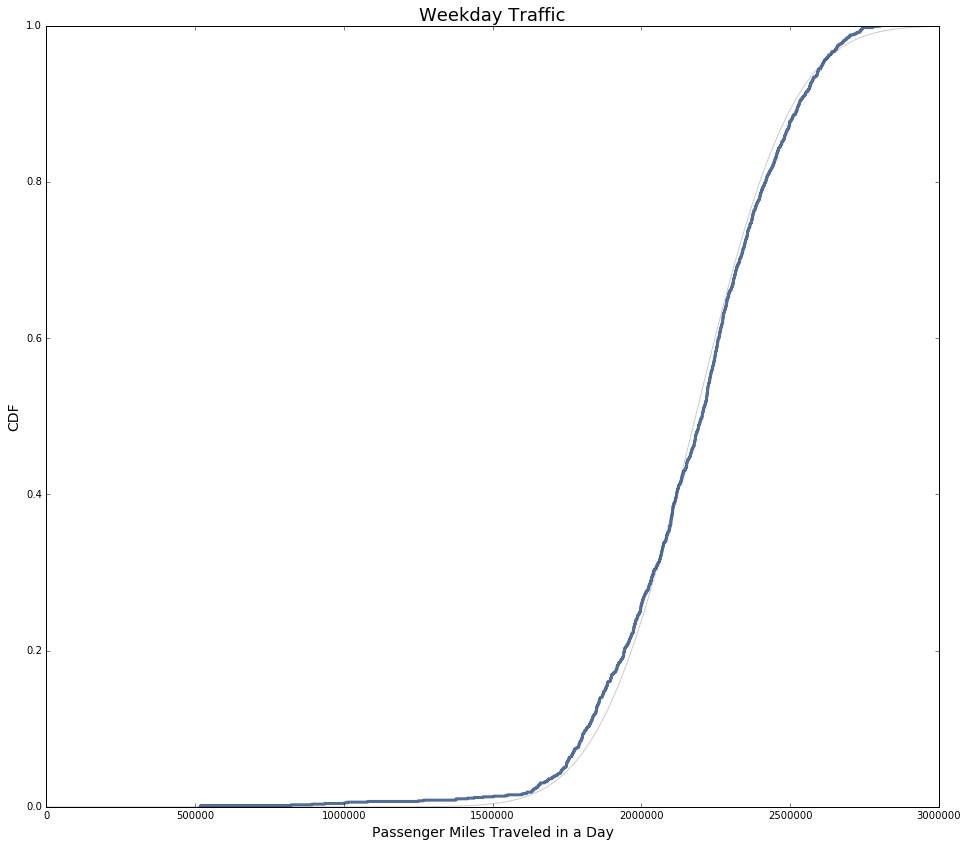

In [46]:
data = weekdays.pmt
mu, var = ts2.TrimmedMeanVar(data, p=0.01)

# plot the model
sigma = math.sqrt(var)
xs, ps = ts2.RenderNormalCdf(mu, sigma, low=0, high=3000000)
cdf = ts2.Cdf(data)

plt.figure(figsize=(16,14))
plt.plot(xs, ps, color='0.8')
#parameters for the resulting graph:
plt.title("Weekday Traffic", fontsize=18)
plt.xlabel("Passenger Miles Traveled in a Day", fontsize=14)
plt.ylabel("CDF", fontsize=14)
# plot the data
tp.Cdf(cdf)
plt.show()

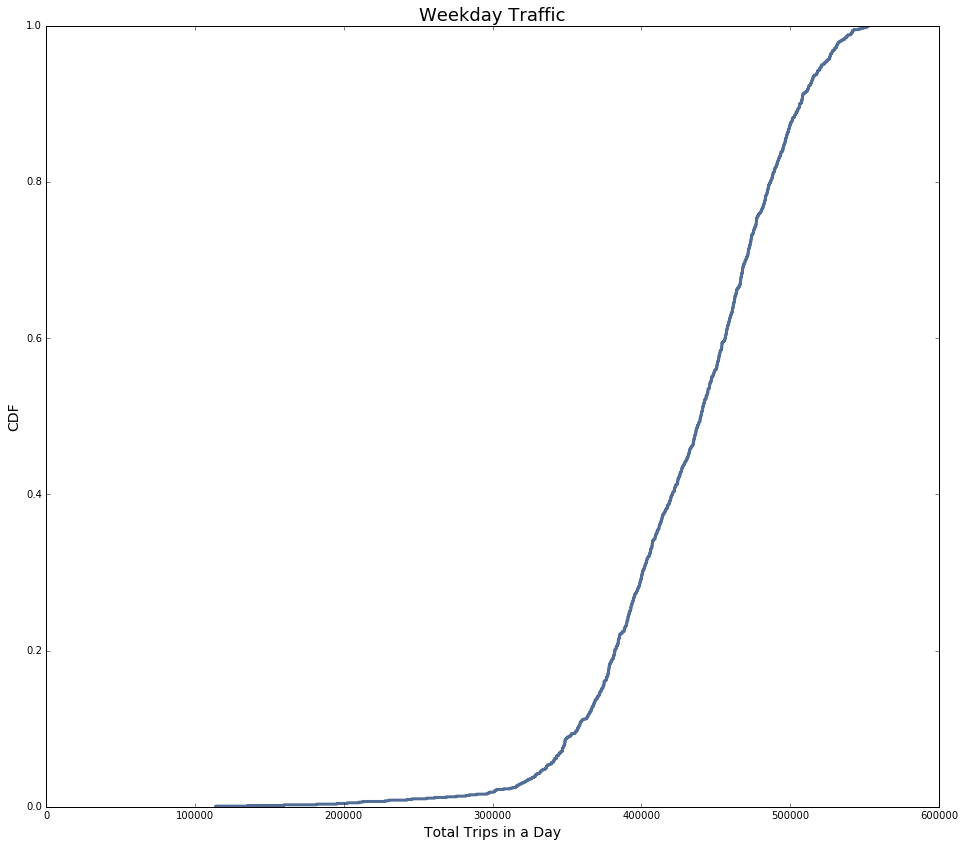

In [47]:
data = weekdays.trips
mu, var = ts2.TrimmedMeanVar(data, p=0.01)

# plot the model
sigma = math.sqrt(var)
xs, ps = ts2.RenderNormalCdf(mu, sigma, low=0, high=60000)
cdf = ts2.Cdf(data)

plt.figure(figsize=(16,14))
plt.plot(xs, ps, color='0.8')
#parameters for the resulting graph:
plt.title("Weekday Traffic", fontsize=18)
plt.xlabel("Total Trips in a Day", fontsize=14)
plt.ylabel("CDF", fontsize=14)
# plot the data
tp.Cdf(cdf)
plt.show()

## Feature Selection: 
### I've transformed the data to include the number of passenger miles traveled per day i.e. (Σ(number of passengers per trip*length of trip)) as well as a simple count of trips per day. It would be useful to understand how similar are the two metrics.

### Checking the Pearson's Correlation between PMT and trips

In [48]:
df = df[df.pmt>0]
data = df.pmt, df.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(df.pmt, df.trips)
print(correlation)
print(pvalue)

0.885399366238
0.0


### It may be that without normalizing the values, we miss some relationship.

C:\Users\Jay Price\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Jay Price\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Jay Price\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Jay Price\Anaconda3\lib\

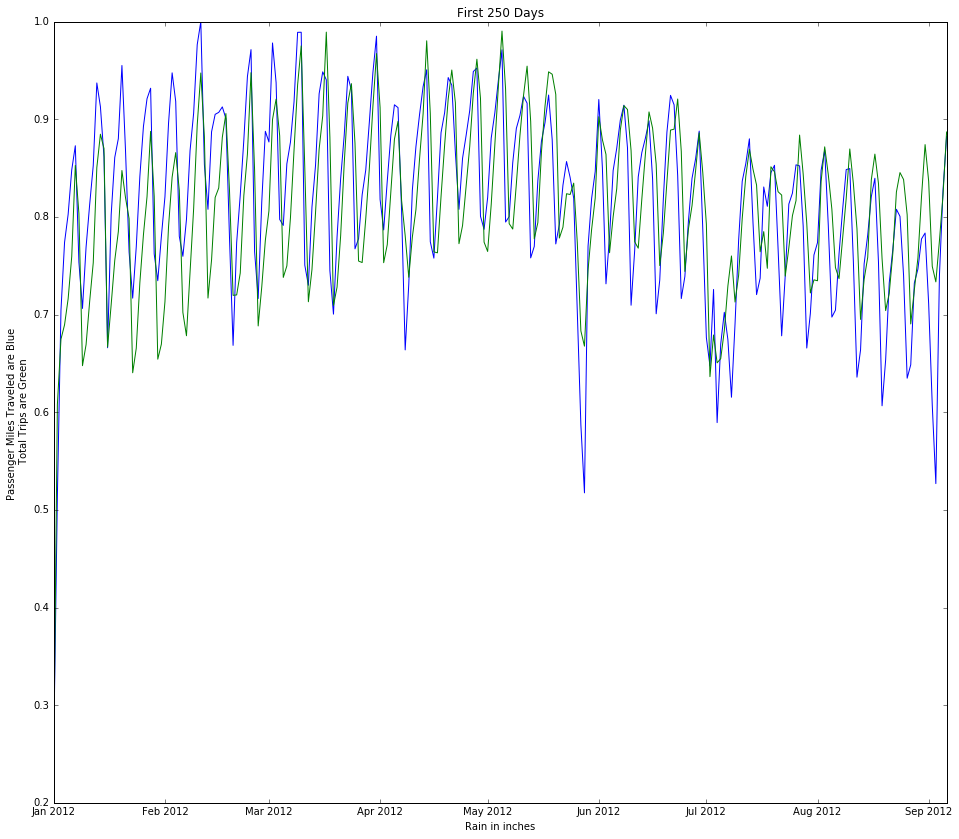

In [49]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
scaled_trips = min_max_scaler.fit_transform(df.trips)
scaled_pmt = min_max_scaler.fit_transform(df.pmt)

fig = plt.figure(figsize=(16,14))

plt.plot_date(df.date[0:250], scaled_trips[0:250], 'b-')
plt.plot_date(df.date[0:250], scaled_pmt[0:250], 'g-')

plt.title("First 250 Days")
plt.xlabel("Rain in inches")
plt.ylabel("Passenger Miles Traveled are Blue \n Total Trips are Green")
plt.show()

fig.autofmt_xdate()

### Checking the Pearson's Correlation on Normalized Values Gives Exactly the Same Answer.

In [50]:
data = scaled_pmt, scaled_trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = ts2.Corr(scaled_pmt, scaled_trips)
print(correlation)
print(pvalue)

0.885399366238
0.0


## Plot the time series for weekend and weekday traffic along with the means

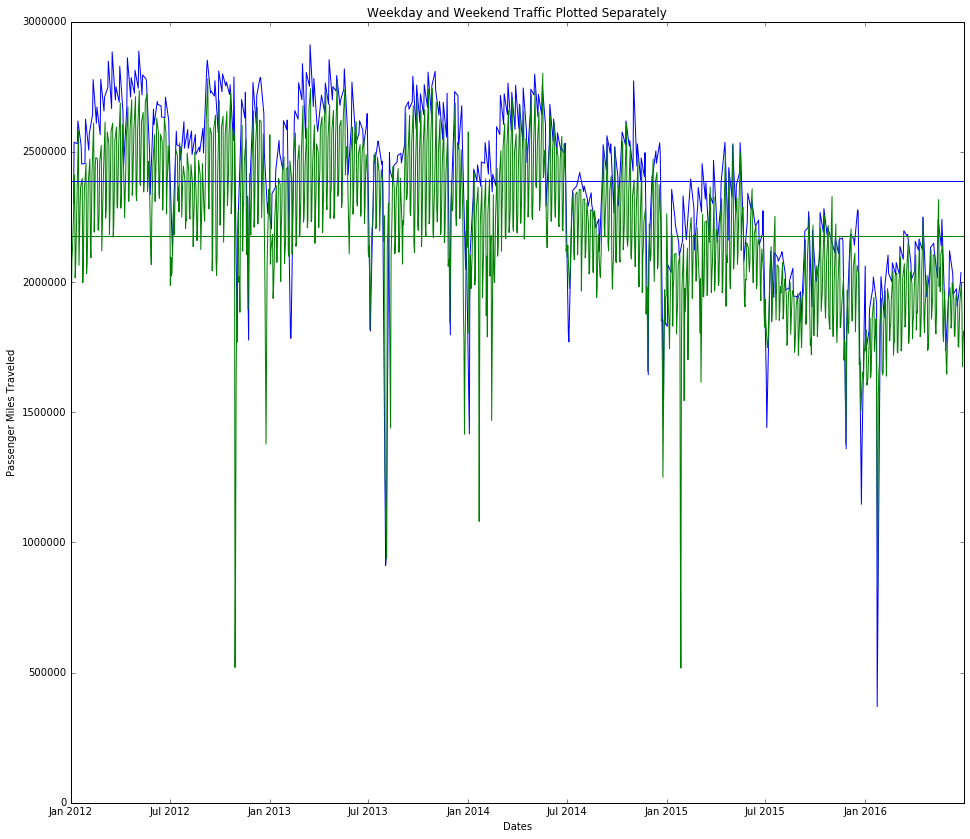

In [51]:
df = df[df.pmt>0]
weekends = df[df.weekday>5]
weekdays = df[df.weekday<6]

fig = plt.figure(figsize=(16,14))
plt.plot_date(weekends.date, weekends.pmt, 'b-')
plt.plot_date(weekdays.date, weekdays.pmt, 'g-')
plt.axhline(y=weekends.pmt.mean(), color='blue', linestyle='-')
plt.axhline(y=weekdays.pmt.mean(), color='green', linestyle='-')
plt.title("Weekday and Weekend Traffic Plotted Separately")
plt.xlabel("Dates")
plt.ylabel("Passenger Miles Traveled")
plt.show()

fig.autofmt_xdate()


# Hypothesis
## There is a statistically significant difference between the sample of entries from weekday and weekend traffic.
### Step 1: Check whether the difference between the means of the samples is statistically signficant.
### Check both metrics: pmt and trips
### Null Hypothesis: The factors affecting both samples are the same; treating them as one sample should not result in different means.

In [52]:
weekdays = df[df.weekday<6]
weekends = df[df.weekday>5]
data = weekends.pmt, weekdays.pmt
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = abs(weekends.pmt.mean()-weekdays.pmt.mean())
print(difference_in_means)
print(pvalue)

212749.59442791855
0.0


In [53]:
data = weekends.trips, weekdays.trips
ht = DiffMeansPermutate(data)
pvalue = ht.PValue()
difference_in_means = weekdays.trips.mean()-weekends.trips.mean()
print(difference_in_means)
print(pvalue)

-43996.164070703846
0.0


In [54]:
weekday_length = weekdays.pmt.mean()/weekdays.trips.mean()
weekend_length = weekends.pmt.mean()/weekends.trips.mean()
print(weekday_length)
print(weekend_length)

5.023298890648746
5.00599793870532


# Hypothesis
## There is a statistically significant correlation or covariance between the amount of rain and yellow taxi traffic.

In [55]:
df = df[df.pmt>0]
weekdays = df[df.weekday<6]
weekends = df[df.weekday>5]

### Checking the Pearson's correlation between rainfall and weekend taxi traffic.

In [56]:
weekend_pmt = weekends.dropna(subset=['rain', 'pmt'])
data = weekend_pmt.rain, weekend_pmt.pmt
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = abs(ts2.Corr(weekend_pmt.rain, weekend_pmt.pmt))
print(correlation)
print(pvalue)

0.0418837990652
0.378


In [57]:
weekend_trips = weekends.dropna(subset=['rain', 'trips'])
data = weekend_trips.rain, weekend_trips.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = abs(ts2.Corr(weekend_pmt.rain, weekend_pmt.trips))
print(correlation)
print(pvalue)

0.0027599652344
0.941


### Checking the Pearson's correlation between rainfall and weekday traffic.

In [58]:
weekday_pmt = weekdays.dropna(subset=['rain', 'pmt'])
data = weekday_pmt.rain, weekday_pmt.pmt
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = abs(ts2.Corr(weekday_pmt.rain, weekday_pmt.pmt))
print(correlation)
print(pvalue)

0.0853439796804
0.006


In [69]:
weekday_trips = weekdays.dropna(subset=['rain', 'trips'])
data = weekday_trips.rain, weekday_trips.trips
ht = CorrelationPermuate(data)
pvalue = ht.PValue()
correlation = abs(ts2.Corr(weekday_trips.rain, weekday_trips.trips))
print(correlation)
print(pvalue)

0.0155367234278
0.591


## So Let's plot Taxi traffic against rainfall for weekdays only

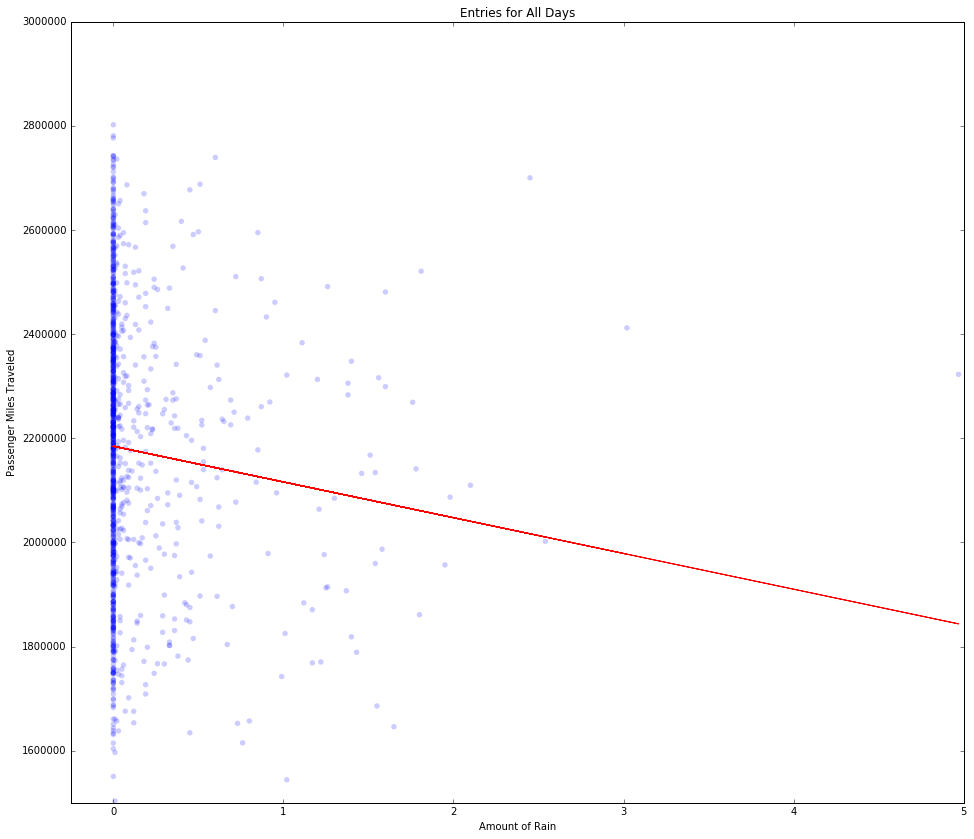

In [63]:
weekends = df[df.weekday<6]
x1 = weekdays.rain
y1 = weekdays.pmt

fig, ax = plt.subplots(figsize=(16,14))
fit1 = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit1[0] * x1 + fit1[1], color='red')
tp.scatter(x1, y1)

plt.title("Entries for All Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Passenger Miles Traveled")
plt.axis([-0.25, 5, 1500000, 3000000])
plt.show()

### We can try to correct for measurement error or sampling bias by plotting the linear regression for a number of samples.

In [81]:
def SamplingDistributions(weekdays, iters=101):
    t = [] 
    for _ in range(iters):
        sample = ts2.ResampleRows(weekdays)
        rain = sample.rain
        pmt = sample.pmt
        estimates = ts2.LeastSquares(rain, pmt)
        t.append(estimates)
    
    inters, slopes = zip(*t)
    return inters, slopes, estimates

def Summarize(estimates, actual=None):
    mean = ts2.Mean(estimates)
    stderr = ts2.Std(estimates, mu=actual)
    cdf = ts2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('Mean: ', mean)
    print('Standard Error: ', stderr)
    print('Confidence Interval: ', ci )

def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    plt.figure(figsize=(16,14))
    plt.title("90 Percent Confidence", fontsize=20)
    plt.xlabel("Passenger Miles Traveled", fontsize=14)
    plt.ylabel("Rain in Inches", fontsize=14)
    plt.axis([-0.25, 5, 1250000, 2500000])
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = ts2.FitLine(xs, inter, slope)
        fys_seq.append(fys)
    
    p = (100-percent) / 2
    percents = p, 100-p
    low, high = ts2.PercentileRows(fys_seq, percents)
    tp.FillBetween(fxs, low, high, **options)
    weekends = df[df.weekday<6]
    x1 = weekdays.rain
    y1 = weekdays.pmt
    fit1 = np.polyfit(x1, y1, deg=1)
    plt.plot(x1, fit1[0] * x1 + fit1[1], color='red')
    tp.Show()

In [82]:
inters, slopes, estimates = SamplingDistributions(weekdays)

In [83]:
Summarize(estimates)

Mean:  1055606.98364
Standard Error:  1137136.1596570616
Confidence Interval:  (-81529.176016854937, 2192743.1432972685)


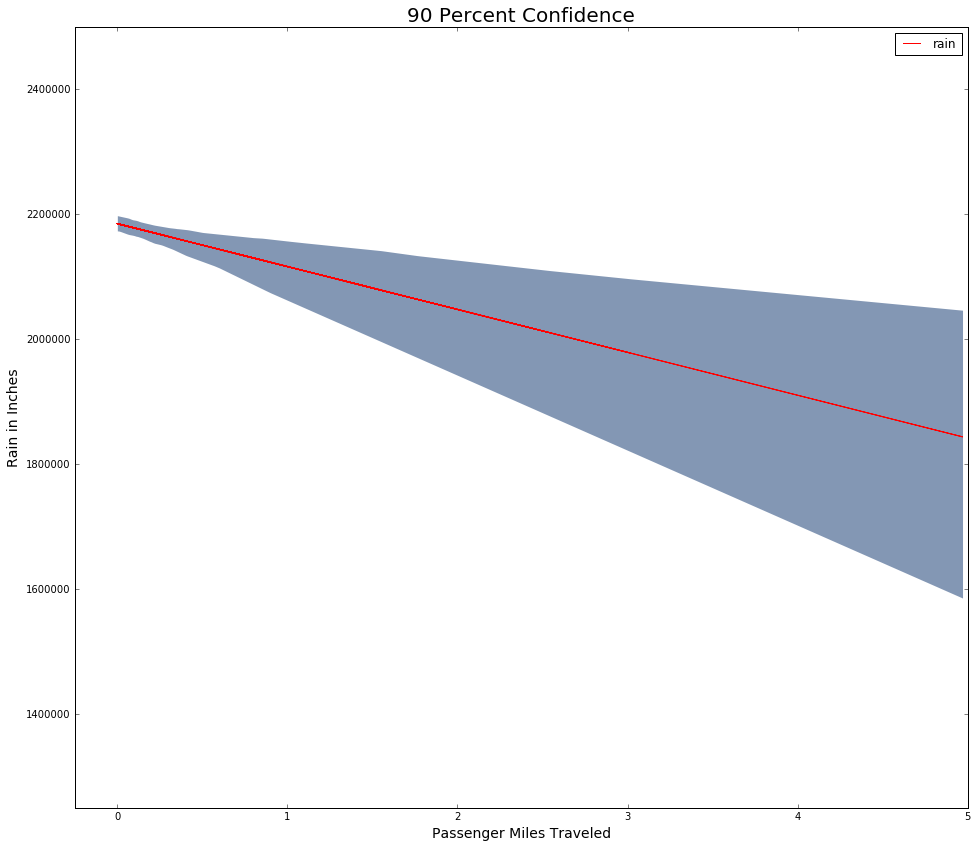

In [86]:
PlotConfidenceIntervals(weekdays.rain, inters, slopes, percent=90)

### Entries and Exits
Plot the histogram for the entries and exits.

In [ ]:
plt.figure(figsize=(12,10))
rain = df.rain
plt.hist(rain, bins=100, range=(0,5))
plt.xlabel("Inches of Rain")
plt.ylabel("Frequency")
plt.axis([0, 5, 0, 100])
plt.show()

In [ ]:
wxd['date'] = pd.to_datetime(wxd.date, format="%Y%m%d")

In [ ]:
merge = MTA.merge(right=wxd, left_on="date", right_on="date", how='inner')

In [ ]:
all_entries = merge.entries_per_hour
rain_days = merge[merge.prcp>0].entries_per_hour
all_entries_pmf = ts2.Pmf(all_entries, label='all_days')
rain_days_pmf = ts2.Pmf(rain_days, 'any_rain')

plt.figure(figsize=(12,10))
tp.Hist(all_entries_pmf, width=1)
tp.Show(title='Subway Entries', ylabel='probability', xlabel='number of entries', axis=[-20, 400, 0, 0.0175])

entries = range(1, 750)
diffs = []
for entry in entries:
    p1 = all_entries_pmf.Prob(entry)
    p2 = rain_days_pmf.Prob(entry)
    diff = 100*(p1-p2)
    diffs.append(diff)

plt.figure(figsize=(12,10))
tp.Bar(entries, diffs)
tp.Show(title="All days included", xlabel="Days with Non-Zero Precipitation",  axis=[0, 500, -0.0075, 0.005])

In [ ]:
clear_days = merge[merge.prcp==0].entries_per_hour
reversed_rain_days = merge[merge.prcp>0].entries_per_hour*-1
rain_days = merge[merge.prcp>0].entries_per_hour
clear_days_pmf = ts2.Pmf(clear_days, label='clear_days')
reversed_rain_days_pmf = ts2.Pmf(reversed_rain_days, 'reverse_rain')

plt.figure(figsize=(12,10))
tp.Hist(clear_days_pmf, width=1)
tp.Hist(reversed_rain_days_pmf, width=1)
tp.Show(ylabel='probability', xlabel='number of entries', axis=[-100, 100, 0, 0.01])

entries = range(0, 750)
diffs = []
for entry in entries:
    p1 = clear_days_pmf.Prob(entry)
    p2 = rain_days_pmf.Prob(entry)
    diff = 100*(p1-p2)
    diffs.append(diff)

plt.figure(figsize=(12,10))
tp.Bar(entries, diffs)
tp.Show(title="Clear Days", xlabel="Days with Non-Zero Precipitation", axis=[0, 250, -0.015, 0.0075])

In [ ]:
clear_mean = merge[merge.prcp==0].entries_per_hour.mean()
any_rain_mean = merge[merge.prcp>0].entries_per_hour.mean()
rain_mean25 = merge[merge.prcp>0.25].entries_per_hour.mean()
rain_mean50 = merge[merge.prcp>0.50].entries_per_hour.mean()
diff = clear_mean - any_rain_mean
print("Clear mean is equal to: ", clear_mean,".")
print("The mean with any rain is equal to: ", any_rain_mean,".")
print("The mean with more than 0.25 inches is equal to: ", rain_mean25,".")
print("The mean with more than 0.5 inches is equal to: ", rain_mean50,".")

In [ ]:
plt.figure(figsize=(12,10))
weather = wxd.prcp
plt.hist(weather, bins=30)
plt.title("2015 Precipitation Including Clear Days as Zero")
plt.xlabel("Amount of Rain")
plt.ylabel("Days with Amount")
plt.axis([0, 2.25, 0, 40])

In [ ]:
plt.figure(figsize=(12,10))
any_rain = wxd[wxd.prcp>0].prcp
plt.hist(any_rain, bins=25)
plt.title("2015 Non-Zero Precipitation Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")

### Mean Entries Against Rainfall
Populate a date frame with all the unique measurements of rainfall in a given data and the corresponding mean entries and exits per period for the corresponding day or days. 

Plot a scatter graph with the mean entries and exits via the measured precipitation.

In [ ]:
work_days = merge[(merge.weekday==1)&(merge.holiday==0)]
weekends = merge[merge.weekday==0]
play_days = merge[(merge.weekday==0)|(merge.holiday==1)]

In [ ]:
mean_rain_df = pd.read_csv("mean_unique_rain.csv")
mean_work_rain_df = pd.read_csv("mean_work_rain.csv")
mean_weekend_rain_df = pd.read_csv("mean_weekend_rain.csv")
mean_play_rain_df = pd.read_csv("mean_play_rain.csv")
median_rain_df = pd.read_csv("median_unique_rain.csv")
median_work_rain_df = pd.read_csv("median_work_rain.csv")
median_weekend_rain_df = pd.read_csv("median_weekend_rain.csv")
median_play_rain_df = pd.read_csv("median_play_rain.csv")

pd.options.mode.chained_assignment = None

In [ ]:
df.head()

When means for all days are calculated:

In [ ]:
x = df[(df.mta>0)&(df.weekend==1)].rain
y = df[(df.mta>0)&(df.weekend==1)].mta

x1 = df[(df.mta>0)&(df.weekend==0)].rain
y1 = df[(df.mta>0)&(df.weekend==0)].mta


fig, ax = plt.subplots(figsize=(14,12))
fig1, ax1 = plt.subplots(figsize=(14,12))
fit = np.polyfit(x, y, deg=1)
fit1 = np.polyfit(x1, y1, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax1.plot(x1, fit1[0] * x1 + fit1[1], color='red')
ax.scatter(x, y)
ax1.scatter(x1, y1)
plt.title("Entries for All Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")
plt.show()

In [ ]:
x1 = df[(df.pmt>0)&(df.weekend==1)].rain
y1 = df[(df.pmt>0)&(df.weekend==1)].pmt

x2 = df[(df.pmt>0)&(df.weekend==2)].rain
y2 = df[(df.pmt>0)&(df.weekend==2)].pmt

x3 = df[(df.pmt>0)&(df.weekend==3)].rain
y3 = df[(df.pmt>0)&(df.weekend==3)].pmt

x4 = df[(df.pmt>0)&(df.weekend==4)].rain
y4 = df[(df.pmt>0)&(df.weekend==4)].pmt

x5 = df[(df.pmt>0)&(df.weekend==5)].rain
y5 = df[(df.pmt>0)&(df.weekend==5)].pmt

x6 = df[(df.pmt>0)&(df.weekend==6)].rain
y6 = df[(df.pmt>0)&(df.weekend==6)].pmt

x7 = df[(df.pmt>0)&(df.weekend==7)].rain
y7 = df[(df.pmt>0)&(df.weekend==7)].pmt

fig, ax = plt.subplots(figsize=(14,12))

fit1 = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit1[0] * x1 + fit1[1], color='red')
ax.scatter(x1, y1, color='blue')

fit2 = np.polyfit(x2, y2, deg=1)
ax.plot(x2, fit2[0] * x2 + fit2[1], color='red')
ax.scatter(x2, y2, color='blue')

fit3 = np.polyfit(x3, y3, deg=1)
ax.plot(x3, fit3[0] * x3 + fit3[1], color='red')
ax.scatter(x3, y3, color='blue')

fit4 = np.polyfit(x4, y4, deg=1)
ax.plot(x4, fit4[0] * x4 + fit4[1], color='red')
ax.scatter(x4, y4, color='blue')

fit5 = np.polyfit(x5, y5, deg=1)
ax.plot(x5, fit5[0] * x5 + fit5[1], color='red')
ax.scatter(x5, y5, color='blue')

fit6 = np.polyfit(x6, y6, deg=1)
ax.plot(x6, fit6[0] * x6 + fit6[1], color='red')
ax.scatter(x6, y6, color='blue')

fit7 = np.polyfit(x7, y7, deg=1)
ax.plot(x7, fit7[0] * x7 + fit7[1], color='red')
ax.scatter(x7, y7, color='blue')

plt.title("Entries for All Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import pandas as pd
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df.trips)
x1_scaled = min_max_scaler.fit_transform(df.pmt)

fig = plt.figure(figsize=(16,14))

plt.plot_date(df.date[1:250], x_scaled[1:250], 'b-')
plt.plot_date(df.date[1:250], x1_scaled[1:250], 'g-')

fig.autofmt_xdate()

When the means are only calculated for work days (not weekends or federal holidays):

In [ ]:
for i in range(len(mean_work_rain_df.index)):
        value = mean_work_rain_df.measurement[i]
        mean_work_rain_df.mean_entries[i] = merge[merge.prcp==value].entries_per_hour.mean()
        mean_work_rain_df.mean_exits[i] = merge[merge.prcp==value].exits_per_hour.mean()

x = mean_work_rain_df.measurement
y = mean_work_rain_df.mean_entries


fig, ax = plt.subplots(figsize=(14,12))
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Entries on Work Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")
plt.show()

x = mean_work_rain_df.measurement
y = mean_work_rain_df.mean_exits

fig, ax = plt.subplots(figsize=(14,12))
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Exits on Work Days")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")
plt.show()

In [ ]:
for i in range(len(mean_weekend_rain_df.index)):
        value = mean_weekend_rain_df.measurement[i]
        mean_weekend_rain_df.mean_entries[i] = merge[merge.prcp==value].entries_per_hour.mean()
        mean_weekend_rain_df.mean_exits[i] = merge[merge.prcp==value].exits_per_hour.mean()

x = mean_weekend_rain_df.measurement
y = mean_weekend_rain_df.mean_entries


fig, ax = plt.subplots(figsize=(14,12))
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Entries on Weekends")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")
plt.show()

x = mean_weekend_rain_df.measurement
y = mean_weekend_rain_df.mean_exits

fig, ax = plt.subplots(figsize=(14,12))
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Exits on Weekends")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")
plt.show()

For work days (neither holiday or weekend), it seems like the trendline stays exactly flat, suggesting that demand for MTA is a lot less elastic against the weather. This makes sense if most people who use the MTA on work days appreciate less choice in their decision to abstain.

When the means are calculated for only federal holidays and weekends:

In [ ]:
for i in range(len(play_rain_df.index)):
        value = play_rain_df.measurement[i]
        play_rain_df.mean_entries.loc[i] = play_days[play_days.prcp==value].period_entries.mean()
        play_rain_df.mean_exits.loc[i] = play_days[play_days.prcp==value].period_exits.mean()

x = play_rain_df.measurement
y = play_rain_df.mean_entries

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Mean Entries Against Precipitation for Weekends & Holidays")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")

x = play_rain_df.measurement
y = play_rain_df.mean_exits

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x, y)
plt.title("Mean Exits Against Precipitation for Weekends & Holidays")
plt.xlabel("Amount of Rain")
plt.ylabel("Frequency")

In [ ]:
workdays_pmf = ts2.Pmf(work_days.period_entries)
play_days_pmf = ts2.Pmf(play_days.period_entries)

#exclude 0, because the difference is so large that it obscures other differences in the frame.
entries = range(10, 750)
diffs = []
for entry in entries:
    p1 = workdays_pmf.Prob(entry)
    p2 = play_days_pmf.Prob(entry)
    diff = 100*(p1-p2)
    diffs.append(diff)

tp.Bar(entries, diffs)
tp.Show(title="Work Days", xlabel="entries \n Weekends and Holidays", ylabel = 'probability', axis=[10, 750, -0.14, 0.04])